# Setup

In [1]:
# https://github.com/slundberg/shap

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import shap

In [2]:
titanic = pd.read_csv("./titanic.csv")

In [3]:
titanic.shape

(891, 12)

In [4]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot:>

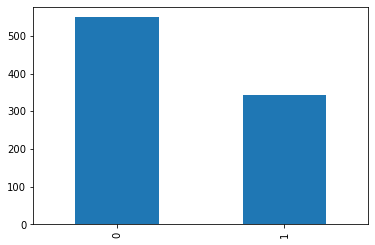

In [5]:
titanic["Survived"].value_counts().plot.bar()

# Preprocess data

In [6]:
X = titanic[["Pclass", "Sex", "Age", "Fare", "SibSp", "Parch"]]
y = titanic["Survived"]

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)
X_train.shape, X_val.shape

((668, 6), (223, 6))

In [8]:
column_trans = ColumnTransformer(
    [
        ('Pclass', OneHotEncoder(dtype='int'),['Pclass']),
        ('Sex', OneHotEncoder(dtype='int'),['Sex']),
        ('Age', SimpleImputer(strategy="median"), ['Age']),
        ('Fare', SimpleImputer(strategy="median"), ['Fare']),
        ('SibSp', SimpleImputer(strategy="median"), ['SibSp']),
        ('Parch', SimpleImputer(strategy="median"), ['Parch'])
    ],
    remainder='drop').fit(X_train)
X_train = column_trans.transform(X_train)
X_val = column_trans.transform(X_val)

In [9]:
feature_names = []
for tr in column_trans.transformers_:
    if hasattr(tr[1], "get_feature_names"):
        features = [f"{tr[0]}_{c[3:]}" for c in tr[1].get_feature_names()]
        feature_names += features
    else:
        feature_names.append(tr[0])
feature_names

['Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_female',
 'Sex_male',
 'Age',
 'Fare',
 'SibSp',
 'Parch']

In [10]:
X_train = pd.DataFrame(X_train, columns=feature_names)
X_val = pd.DataFrame(X_val, columns=feature_names)

In [11]:
X_train.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age,Fare,SibSp,Parch
0,0.0,0.0,1.0,0.0,1.0,28.0,7.8958,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,17.0,7.9250,4.0,2.0
2,0.0,0.0,1.0,0.0,1.0,30.0,16.1000,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,22.0,7.2500,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,45.0,13.5000,0.0,0.0


In [12]:
X_val.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age,Fare,SibSp,Parch
0,0.0,0.0,1.0,0.0,1.0,29.0,14.4583,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,29.0,7.5500,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,7.0,29.1250,4.0,1.0
3,1.0,0.0,0.0,1.0,0.0,29.0,146.5208,1.0,0.0
4,0.0,0.0,1.0,1.0,0.0,29.0,15.2458,0.0,2.0


# Train model

In [13]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=0,
    class_weight="balanced")
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, random_state=0)

In [14]:
y_val_prob = model.predict_proba(X_val)[:, 1]
y_val_pred = model.predict(X_val)

In [15]:
val_auc = roc_auc_score(y_val, y_val_prob)
print(f'Val AUC={val_auc}')

Val AUC=0.8878040424803014


In [16]:
val_acc = accuracy_score(y_val, y_val_pred)
print(f'Val ACC={val_acc}')

Val ACC=0.8026905829596412


(array([71., 30., 10., 31.,  3.,  4., 33.,  1.,  5., 35.]),
 array([0.16704545, 0.24541934, 0.32379323, 0.40216711, 0.480541  ,
        0.55891489, 0.63728878, 0.71566267, 0.79403655, 0.87241044,
        0.95078433]),
 <BarContainer object of 10 artists>)

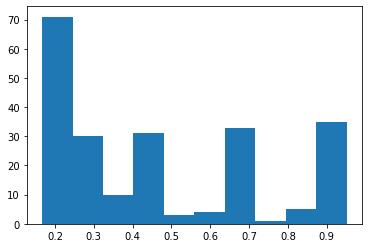

In [17]:
plt.hist(y_val_prob)

# Build Shap values

In [18]:
explainer = shap.TreeExplainer(model)

In [19]:
# Average prediction for class 0 and 1
# Trung binh predict = trung binh xác xuất Survived.
# trung binh class 1 = 50%
explainer.expected_value

array([0.49775564, 0.50224436])

In [20]:
explain_shap = explainer.shap_values(X_val)

In [21]:
X_val.shape

(223, 9)

In [22]:
# Shap value for class 1 (Survived = 1)
# for each sample and each feature in validation data
explain_shap[1].shape

(223, 9)

In [23]:
# shap value for sample id=0 in val data
for c, v, s in zip(X_val.columns, X_val.iloc[0], explain_shap[1][0]):
    print("{} = {}, Shap = {}".format(c, v, s))

Pclass_1 = 0.0, Shap = -0.017136772063917612
Pclass_2 = 0.0, Shap = -0.003281451072402799
Pclass_3 = 1.0, Shap = -0.0384149037759266
Sex_female = 0.0, Shap = -0.07642586753868068
Sex_male = 1.0, Shap = -0.11896391110549497
Age = 29.0, Shap = -0.0075109987048509325
Fare = 14.4583, Shap = 0.0011860739958287126
SibSp = 0.0, Shap = 0.0020000702245500626
Parch = 0.0, Shap = -0.0017524521536984965


In [24]:
explain_shap_df = pd.DataFrame(explain_shap[1], columns=X_val.columns)

In [25]:
explain_shap_df.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age,Fare,SibSp,Parch
0,-0.017137,-0.003281,-0.038415,-0.076426,-0.118964,-0.007511,0.001186,0.002000,-0.001752
1,-0.017515,-0.003032,-0.035165,-0.073075,-0.119106,-0.005334,-0.053729,0.001358,-0.001593
2,-0.018542,-0.005530,-0.057515,-0.049788,-0.074994,0.086185,0.016398,-0.055780,0.011291
3,0.055406,-0.002813,0.063834,0.108820,0.169844,-0.001585,0.041365,0.008656,0.002452
4,-0.018286,-0.009250,-0.075489,0.104567,0.161969,0.000022,0.004430,0.007179,-0.004628


# Plot Feature Importance

Quan tâm đến size của ảnh hưởng nên lấy trung bình của ABS shap -> ranking.

Text(0.5, 1.0, 'Feature Importance')

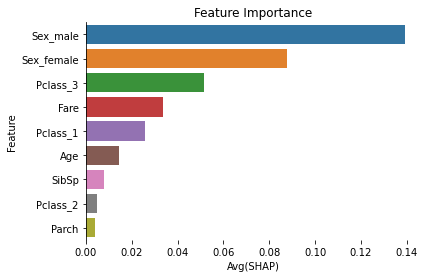

In [26]:
feat_imp = (
    explain_shap_df.abs().mean(axis=0)
    .sort_values(ascending=False)
    .to_frame("Avg(SHAP)")
    .reset_index()
    .rename(columns={"index": "Feature"})
)
fig, ax = plt.subplots()
sns.barplot(x="Avg(SHAP)", y="Feature", data=feat_imp, ax=ax)
sns.despine(fig, bottom=True, top=True, right=True)
ax.set_title("Feature Importance")

# Plot PDP

PDP trend của Fare khá match với PDP của sklearn.

Plot ra từng sample còn show đc distribution của sample, chỗ nào nhiều ít, chỗ nào variance nhiều.

Text(0.5, 1.0, 'PDP Fare')

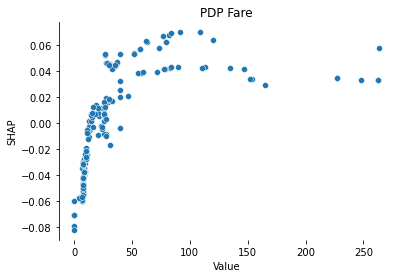

In [27]:
feature = "Fare"
pdp = pd.DataFrame(
    {
        "Feature": feature,
        "Value": X_val[feature],
        "SHAP": explain_shap_df[feature],
    }
)
fig, ax = plt.subplots()
sns.scatterplot(x="Value", y="SHAP", data=pdp, ax=ax)
sns.despine(fig, bottom=True, top=True, right=True)
ax.set_title(f"PDP {feature}")

Text(0.5, 1.0, 'PDP Pclass_1')

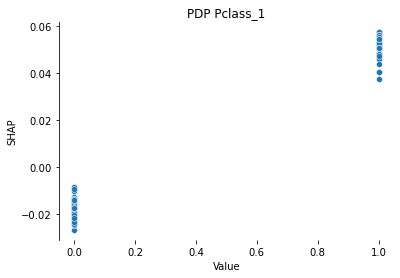

In [28]:
feature = "Pclass_1"
pdp = pd.DataFrame(
    {
        "Feature": feature,
        "Value": X_val[feature],
        "SHAP": explain_shap_df[feature],
    }
)
fig, ax = plt.subplots()
sns.scatterplot(x="Value", y="SHAP", data=pdp, ax=ax)
sns.despine(fig, bottom=True, top=True, right=True)
ax.set_title(f"PDP {feature}")

Text(0.5, 1.0, 'PDP Pclass_3')

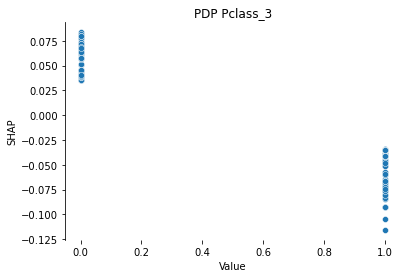

In [29]:
feature = "Pclass_3"
pdp = pd.DataFrame(
    {
        "Feature": feature,
        "Value": X_val[feature],
        "SHAP": explain_shap_df[feature],
    }
)
fig, ax = plt.subplots()
sns.scatterplot(x="Value", y="SHAP", data=pdp, ax=ax)
sns.despine(fig, bottom=True, top=True, right=True)
ax.set_title(f"PDP {feature}")

# Explain sample id = 0

In [30]:
sample_id = 0
sample_explain = pd.DataFrame(
    {
        "Value": X_val.iloc[sample_id, :],
        "SHAP": explain_shap_df.iloc[sample_id, :],
    }
).sort_values(["SHAP"], ascending=False)
sample_explain

,Value,SHAP
SibSp,0.0000,0.002000
Fare,14.4583,0.001186
Parch,0.0000,-0.001752
Pclass_2,0.0000,-0.003281
Age,29.0000,-0.007511
Pclass_1,0.0000,-0.017137
Pclass_3,1.0000,-0.038415
Sex_female,0.0000,-0.076426
Sex_male,1.0000,-0.118964


In [36]:
# Predict %
y_val_prob[0]

0.2419441518764366

In [31]:
# Label
if y_val.iloc[sample_id] == 1:
    print("{} {}".format(sample_id, "Survived"))
else:
    print("{} {}".format(sample_id, "Died"))

0 Died


In [32]:
# Process data for viz purpose
sample_explain["Value_round"] = np.round(
    sample_explain["Value"], decimals=2
)
sample_explain = sample_explain.reset_index()
sample_explain = sample_explain.rename(columns={"index": "Feature"})
sample_explain["Feature"] = (
    sample_explain["Feature"].astype(str)
    + "="
    + sample_explain["Value_round"].astype(str)
)

Text(0.5, 1.0, 'Sample 0 Explain')

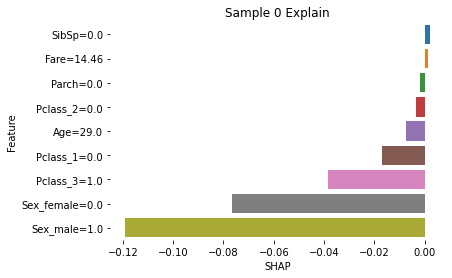

In [33]:
fig, ax = plt.subplots()
sns.barplot(x="SHAP", y="Feature", data=sample_explain, ax=ax)
sns.despine(fig, left=True, bottom=True, top=True, right=True)
ax.set_title(f"Sample {sample_id} Explain")

Shap value cua feature Sex_male=1 la -0.12. Nghia la: 

trong tinh huong nay (Scikit Learn Library, Random Forest model, Binary Classification, Titanic Dataset), feature male=1 kéo dự đoán xuống 1 khoảng 12%.

Do expected value trong tinh huong nay la Probabilty.

In [38]:
# Check xem 4 yếu tố quan trong nhất kéo predict đến mức nào?
0.502 - 0.12 - 0.08 - 0.04 - 0.02

0.24200000000000002

# End